In [1]:
!pip install import-ipynb pandas-datareader
!pip install pandas-datareader -U
!pip install nltk textblob preprocessor tweet-preprocessor tweepy
!pip install keras sklearn

In [2]:

import tweepy
from textblob import TextBlob
from preprocessor.api import clean
import statistics
from typing import List

import math
import pandas_datareader as web
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime,timedelta


In [3]:
def predict(stock: str):
    plt.style.use ('fivethirtyeight')
    

    #fecha de hoy
    today = str(datetime.today().year)+"-"+str(datetime.today().month)+"-"+str(datetime.today().day)


    df = web.DataReader(stock,data_source='yahoo', start='2012-01-01', end = today)

    plt.figure(figsize=(16,8))
    plt.title('Close price history')
    plt.plot(df['Close'])
    plt.xlabel('Date', fontsize=18)
    #plt.ylabel('Close Price USD ($)', fontsize=18)



    dataset = df.filter(['Close']).values

    train_data_len = math.ceil(len(dataset) * 0.95)


    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(dataset)


    train_data = scaled_data[0:train_data_len,:]

    x_train = []
    y_train = []

    for i in range (30,len(train_data)):
        x_train.append(train_data[i-30:i, 0])
        y_train.append(train_data[i , 0])




    #convertir listas a arreglos numpy
    x_train,y_train = np.array(x_train), np.array(y_train)


    #Reshape
    x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


    model = Sequential()

    model.add(LSTM(50,return_sequences=True, input_shape = (x_train.shape[1],1 )))
    model.add(LSTM(50,return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam',loss='mean_squared_error')

    model.fit(x_train,y_train,batch_size=1,epochs=1)


    test_data = scaled_data[train_data_len - 30 : ,:]

    x_test = []
    y_test = dataset[train_data_len:, :]
    for i in range (30,len(test_data)):
        x_test.append(test_data[i-30:i, 0])



    x_test = np.array(x_test)


    x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)


    rmse = np.sqrt(np.mean(predictions - y_test)**2)


    train = df.filter(['Close'])[:train_data_len]
    valid = df.filter(['Close'])[train_data_len:]
    valid['Predictions'] = predictions
    #Visualize the data

    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date',fontsize=18)
    #plt.ylabel=('Close Price USD ($)',18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.legend(['Train','Val','Predictions'], loc = 'lower right')
    plt.show()


    apple_quote=web.DataReader(stock,data_source='yahoo',start='2012-01-01',end=today)
    new_df = apple_quote.filter(['Close'])

    last_30_days = new_df[-100:].values
    last_30_days_scaled = scaler.fit_transform(last_30_days)
    
    X_test = []
    X_test.append(last_30_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    pred_price = model.predict(X_test)
    pred_price =scaler.inverse_transform(pred_price)
    print("El precio estimado de ",stock,pred_price)
    print("Con un error medio de ",rmse)

In [4]:

def get_tweets (keyword:str) ->List[str]:
    consumer_key= "9gkhAIK0musfRpGEs5cmYlxON"
    consummer_secret = "xIHs0a0lrjd7UZl1MCGMfqnq4voMaWdnuunTtuxS6kouiA5XZy"
    auth = tweepy.AppAuthHandler(consumer_key,consummer_secret)
    api = tweepy.API(auth)
    all_tweets = []
    for tweet in tweepy.Cursor(api.search,q=keyword,tweet_mode='extended', lang='en').items(50):
        all_tweets.append(tweet.full_text)
    return all_tweets
def clean_teets(all_tweets:List[str]) -> List[str]:
    tweets_clean = []
    for tweet in all_tweets:
        tweets_clean.append(clean(tweet))
    return tweets_clean
def get_sentiment(all_tweets:List[str]) -> List[float]:
    sentiment_scores = []
    for tweet in all_tweets:
        blob = TextBlob(tweet)
        blob = TextBlob(tweet)
        sentiment_scores.append(blob.sentiment.polarity)
    return sentiment_scores
def generate_average_sentiment_score(tweets) -> int:
    tweets_clean = clean_teets(tweets)
    sentiment_scores = get_sentiment(tweets_clean)
    average_score  = statistics.mean(sentiment_scores)
    return average_score

def npl_ability():
    print("Ingresa los stocks que deseas comparar el sentimiento de las personas (2)")
    print("Ex: Apple, Twitter, Facebook, Tesla")
    stock1 = input("Ingresa el primer Stock: ")
    stock2 = input("Ingresa el segundo Stock: ")


    


    tweetsStock1 = get_tweets(stock1)
    tweetsStock2 = get_tweets(stock2)

    stock1Coef = generate_average_sentiment_score(tweetsStock1)
    stock2Coef = generate_average_sentiment_score(tweetsStock2)
    print (stock1 +" "+ str(stock1Coef))
    print (stock2+" " + str(stock2Coef))

    if stock1Coef>stock2Coef:
      print(stock1, " tiene una opinión más favorable que ",stock2)
    else:
      print(stock2, " tiene una opinión más favorable que ",stock1)



In [5]:
def learning_ability():
    print("Ingresa el stock al que deseas predecir su comportamiento")
    print("Ex:\nBitcoin -> BTC-USD\nApple -> AAPL\nTesla -> TSLA")
    print("Para buscar el código del stock, busque en la siguiente página https://finance.yahoo.com/")
    stock = input("Ingresa el código: ")
    
    predict(stock)
    

Bienvenido al agente de inversión, digital el número de la actividad que deseas realizar
(5). Habilidad de predecir stocks
(6). Habilidad de comparar stocks (2)
Ingresa el número 5
Ingresa el stock al que deseas predecir su comportamiento
Ex:
Bitcoin -> BTC-USD
Apple -> AAPL
Tesla -> TSLA
Para buscar el código del stock, busque en la siguiente página https://finance.yahoo.com/
Ingresa el código: BTC-USD
2444/2444 [==============================] - 38s 15ms/step - loss: 0.0017


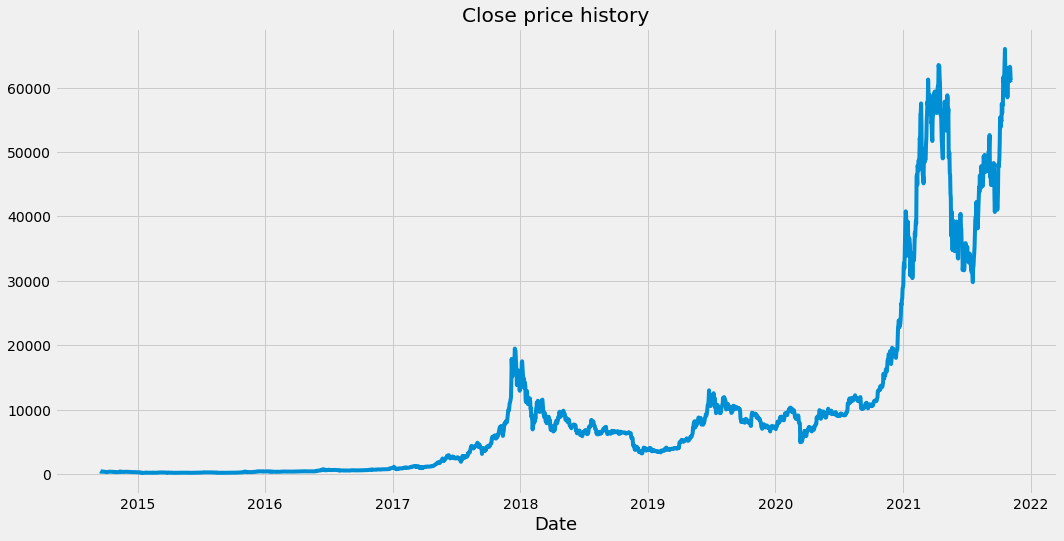

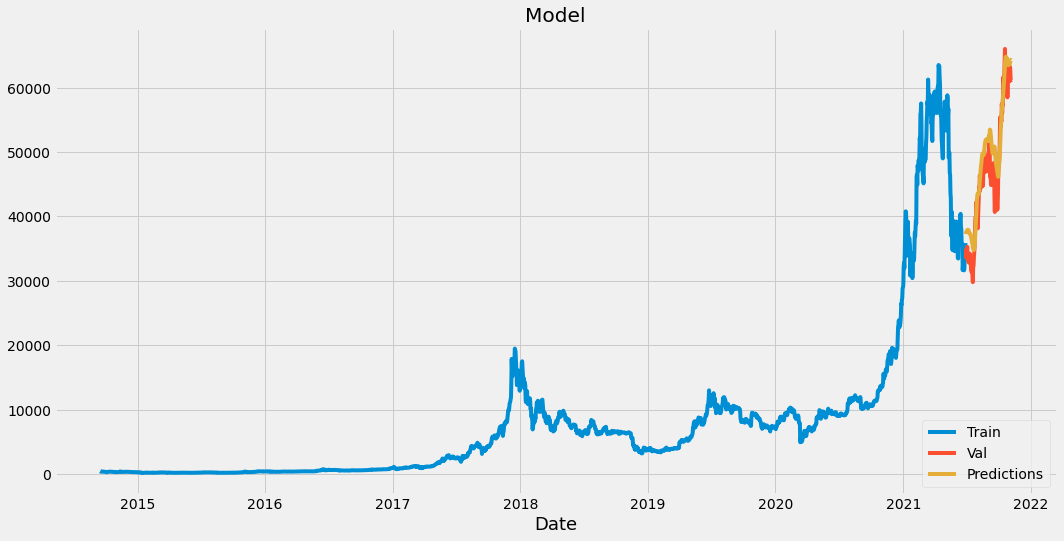

El precio estimado de  BTC-USD [[63035.52]]
Con un error medio de  2461.2296574519232
Bienvenido al agente de inversión, digital el número de la actividad que deseas realizar
(5). Habilidad de predecir stocks
(6). Habilidad de comparar stocks (2)


In [ ]:
while True:
    print("Bienvenido al agente de inversión, digital el número de la actividad que deseas realizar")
    print("(5). Habilidad de predecir stocks")
    print("(6). Habilidad de comparar stocks (2)")
    choose = int(input("Ingresa el número "))
    if choose == 6:
      npl_ability()
    elif choose==5:
      learning_ability()
